In [1]:
# %matplotlib nbagg


In [2]:
import numpy as np
import strid
import matplotlib.pyplot as plt
import scipy.signal

### Importing system data 

In [3]:
data = np.load("results/data-combined.npz")
y = data["y"]
fs = data["fs"]
true_f = data["true_frequencies"]
true_xi = data["true_damping"]
true_modeshapes = data["true_modeshapes"]

In [4]:
ssid = strid.CovarianceDrivenStochasticSID(y, fs)
# help(strid.CovarianceDrivenStochasticSID)

In [5]:
modes = {}
for i, order in enumerate(range(5, 50, 1)):
    A, C, G, R0 = ssid.perform(order, 25)
    modes[order] = strid.Mode.find_modes_from_ss(A, C, ssid.fs) 
# modes.pop(15)

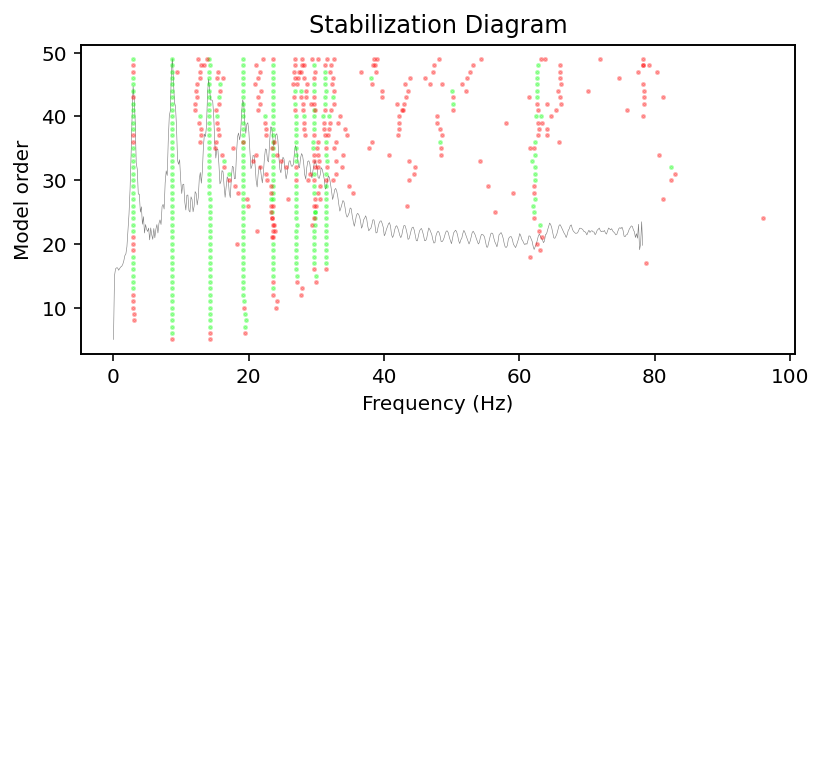

In [6]:
stabdiag = strid.StabilizationDiagram()
stabdiag.plot(modes)

# help(strid.StabilizationDiagram)

f, psd = ssid.psdy(nperseg=2**10)
stabdiag.axes_psd.semilogy(f, np.trace(np.abs(psd)), color=(0., 0., 0., .5), lw=.3)


#### Transforming from STRID to KOMA format

In [7]:
from STRID_to_KOMA import *
modes_temp=remove_neg(modes)
lambd,phi,orders=transform(modes_temp)

### Importing KOMA: 

In [8]:
import koma.oma, koma.plot
import koma.clustering
from scipy.signal import detrend, welch, resample
import pandas as pd

Setting stabilization criteria

In [9]:
s=1
stabcrit = {'freq':0.2, 'damping': 0.2, 'mac': 0.2}
lambd_stab, phi_stab, orders_stab, ix_stab = koma.oma.find_stable_poles(lambd, phi, orders, s, stabcrit=stabcrit, indicator='mac')

Calling KOMA clustering algorithm

In [10]:
pole_clusterer = koma.clustering.PoleClusterer(lambd_stab, phi_stab, orders_stab, min_cluster_size=10, min_samples=10, scaling={'mac':1.0, 'lambda_real':1.0, 'lambda_imag': 1.0})
prob_threshold = 0.5   #probability of pole to belong to cluster, based on estimated "probability" density function
args = pole_clusterer.postprocess(prob_threshold=prob_threshold, normalize_and_maxreal=True)

xi_auto, omega_n_auto, phi_auto, order_auto, probs_auto, ixs_auto = koma.clustering.group_clusters(*args)
xi_mean = np.array([np.mean(xi_i) for xi_i in xi_auto])
fn_mean = np.array([np.mean(om_i) for om_i in omega_n_auto])/2/np.pi

xi_std = np.array([np.std(xi_i) for xi_i in xi_auto])
fn_std = np.array([np.std(om_i) for om_i in omega_n_auto])/2/np.pi

Testing for plotting


C:\Users\olebj\AppData\Local\Temp\ipykernel_4540\3248717288.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.show(plot_stab_from_KOMA(omega_n_auto,order_auto,np.array(lambd),np.array(orders)))


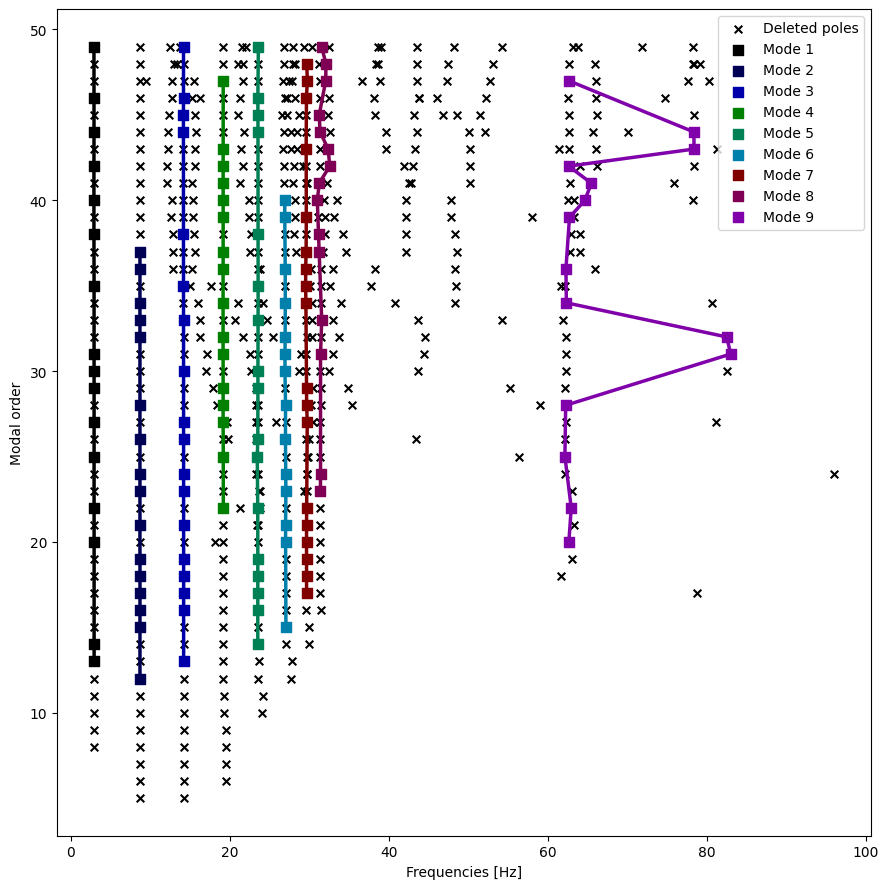

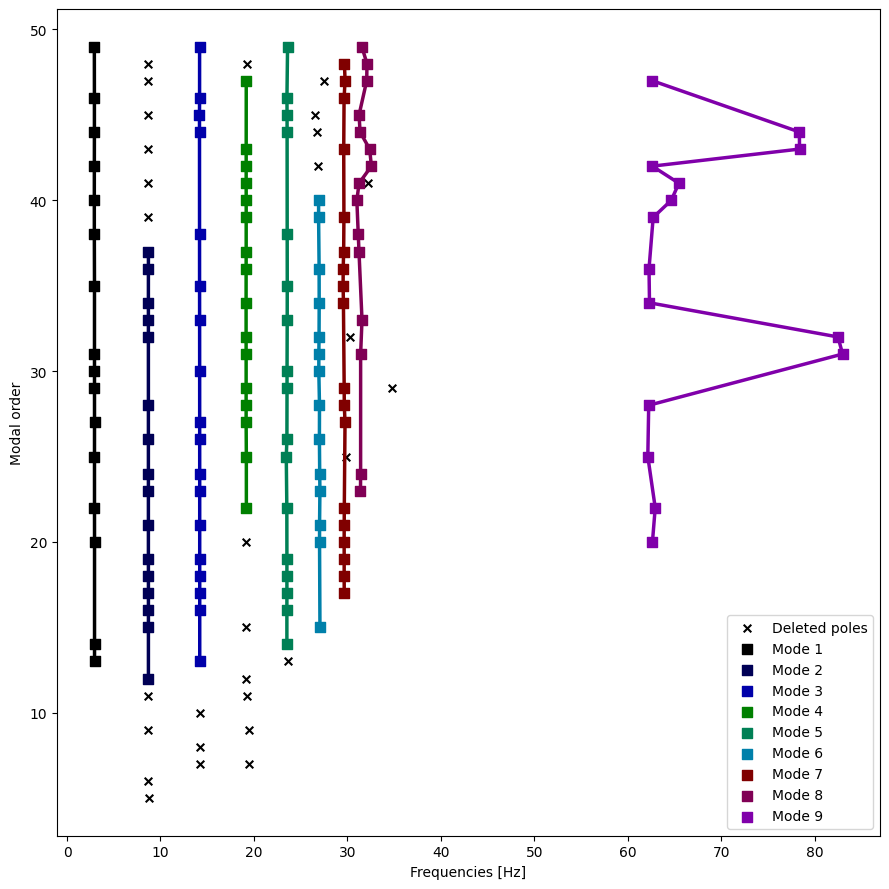

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
c:\Users\olebj\OneDrive - NTNU\00Master - Onedrive\OB ymse\modal-tracking-thesis-spring-2023\KOMA_test\plot_stabdia_clusters.py:47: RuntimeWarning: invalid value encountered in divide
  freq_i=np.imag(lambd_i)/(np.sqrt(1-xi**2))


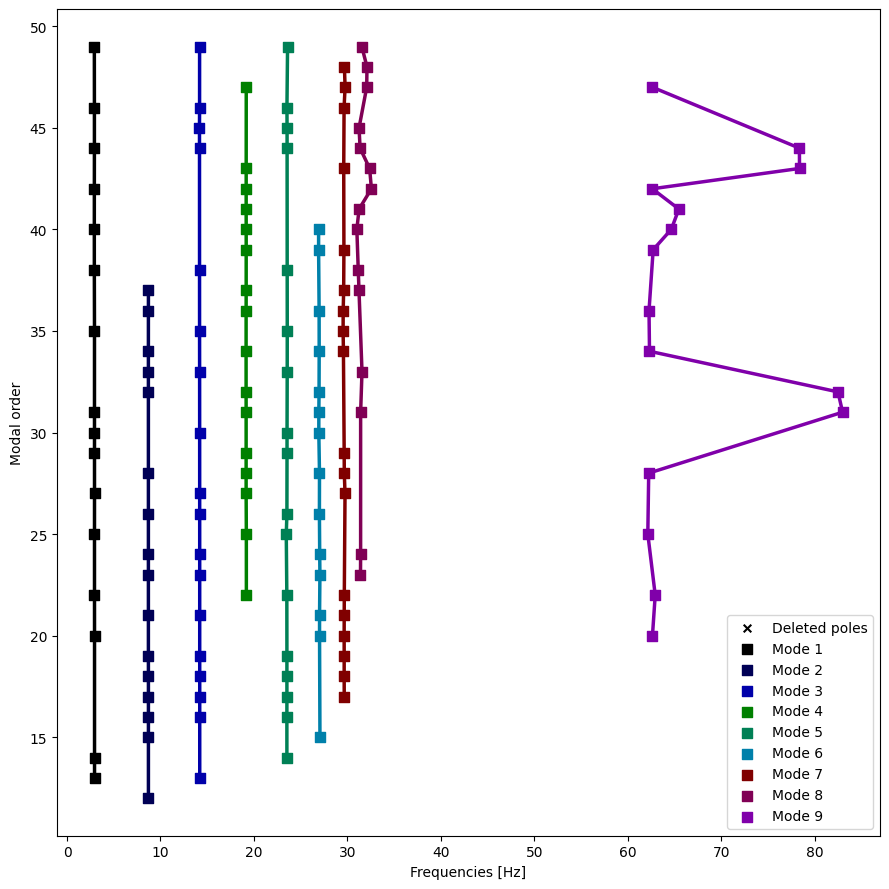

In [13]:
from plot_stabdia_clusters import *

plt.show(plot_stab_from_KOMA(omega_n_auto,order_auto,np.array(lambd),np.array(orders)))
plt.show(plot_stab_from_KOMA(omega_n_auto,order_auto,lambd_stab,orders_stab))
plt.show(plot_stab_from_KOMA(omega_n_auto,order_auto))

In [ ]:
# Print table
import pandas as pd
res_data = np.vstack([fn_mean, 100*xi_mean]).T
results = pd.DataFrame(res_data, columns=['$f_n$ [Hz]', r'$\xi$ [%]'])
results

,$f_n$ [Hz],$\xi$ [%]
0,2.934962,5.075260
1,8.706834,2.826768
2,14.189168,3.033359
3,19.167325,3.443619
4,23.534106,3.669270
5,26.987008,4.377265
6,29.640423,4.969610
7,31.576614,5.393928
8,67.648295,11.280512


In [ ]:
# Group only a selected quantity (e.g. indices)
lambd_used, phi_used, order_stab_used, group_ixs, all_single_ix, probs = pole_clusterer.postprocess(prob_threshold=prob_threshold)
grouped_ixs = koma.clustering.group_array(all_single_ix, group_ixs)       # for instance the indices only,
grouped_phis = koma.clustering.group_array(phi_used, group_ixs, axis=1)   # or the phis only

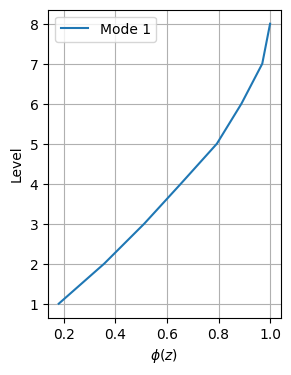

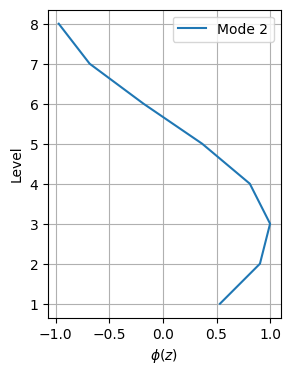

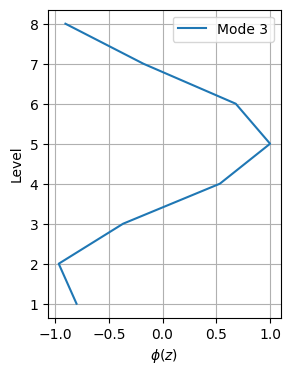

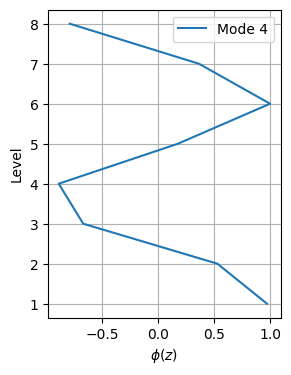

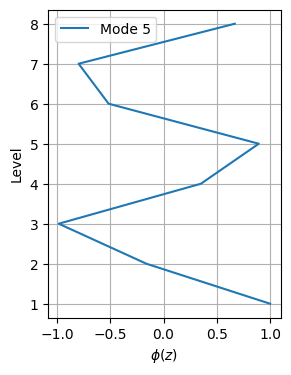

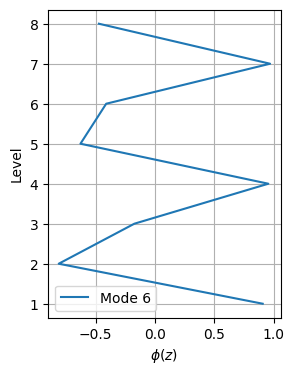

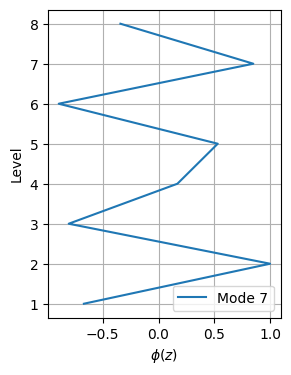

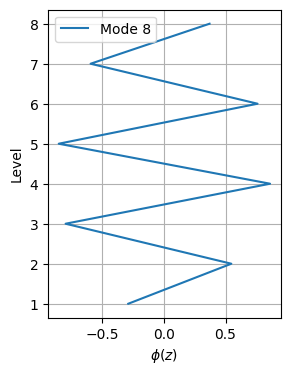

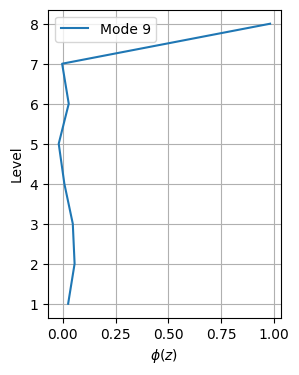

In [ ]:
# Mode shapes
for mode,phis in enumerate(grouped_phis):
    plt.figure(figsize=(3,4))
    plt.plot(np.real(np.mean(phis, axis=1)), np.arange(len(phis))+1, label=f'Mode {mode+1}')
    
    plt.xlabel('$\phi(z)$')
    plt.ylabel('Level')
    plt.yticks(np.arange(len(phis))+1)
    plt.grid('on')
    plt.legend()
    plt.show()

In [ ]:
modes={1:[1,2,3],3:[5,6,7,2,7,7]}

for key in modes: 
    temp=[]
    for i,m in enumerate(modes[key]):
        if not m==7:              # numerical problem with using exact 0.          
            temp.append(m)
    modes[key]=temp
print(modes)

{1: [1, 2, 3], 3: [5, 6, 2]}


In [ ]:
a=[1,2,3,4]
print(type(a))
print(type(np.array(a)))

<class 'list'>
<class 'numpy.ndarray'>
